In [17]:
import glob

import matplotlib.pyplot as plt
import numpy as np
import tifffile

from natsort import natsorted
from sklearn.linear_model import LinearRegression

%matplotlib inline
plt.style.use('seaborn-v0_8-notebook')

def load_tiff_directory(directory_path: str):
    tiff_paths = natsorted(glob.glob(directory_path + '*.tif*'))
    curr_img = tifffile.imread(tiff_paths[0])
    images = np.empty((len(tiff_paths), curr_img.shape[0], curr_img.shape[1]), dtype=np.float32)
    images[0] = curr_img

    for i, tiff_path in enumerate(tiff_paths[1:]):
        images[i+1] = tifffile.imread(tiff_path)
        
    return images

## Measure readout noise

### Data: 
A sequence of images (∼ 100) from the camera with NO light hitting the detector at an extremely short exposure time (∼ 1 ms).

### Exercise instructions:
Measure the standard deviation of each pixels value across the movie (use ImageJ). What is the average noise (standard deviation in counts) across pixels?

In [18]:
def measure_readout_noise(im_data, downsample=5):
    im_data = im_data[:, ::downsample, ::downsample]
    
    return np.std(im_data, axis=0, ddof=1, dtype=np.float32)

def calc_plot_readout_noise(im_data, axis, downsample=5):
    pix_dev = measure_readout_noise(im_data, downsample)
    mean_dev = np.mean(pix_dev, dtype=np.float32)
    
    axis.hist(pix_dev.flatten(), bins=100)
    axis.axvline(mean_dev, color='r', linestyle='--')
    axis.text(0.8, 0.8, f'Mean: {mean_dev:.3f}', ha='center', va='center', transform=axis.transAxes)
    axis.set_ylabel('Count')
    axis.set_xlabel('Standard deviation')
    
    return mean_dev

def plot_readout_noise_multiple_gain(gain_levels: list[str], path_stub: str,  downsample: int):
    num_plots = (len(gain_levels) + 1)// 2
    
    fig, ax = plt.subplots(num_plots, 2, figsize=(14, 14))
    mean_devs = []
    bias = []
    
    for i, gain in enumerate(gain_levels):
        read_noise_images = load_tiff_directory(f'{path_stub}{gain}dB/')
        bias.append(np.mean(read_noise_images, dtype=np.float32))
        mean_devs.append(calc_plot_readout_noise(read_noise_images, ax[i//2][i%2], downsample))
        ax[i//2][i%2].set_title(f'{gain}dB')
        
    plt.show()
    
    fig, ax = plt.subplots()
    ax.plot(gain_levels, mean_devs, marker='o')
    ax.set_xlabel('Gain (dB)')
    ax.set_ylabel('Read noise (counts)')
    plt.show()
    
    return bias

Let's plot the readout noise for the Basler camera at different gain levels.

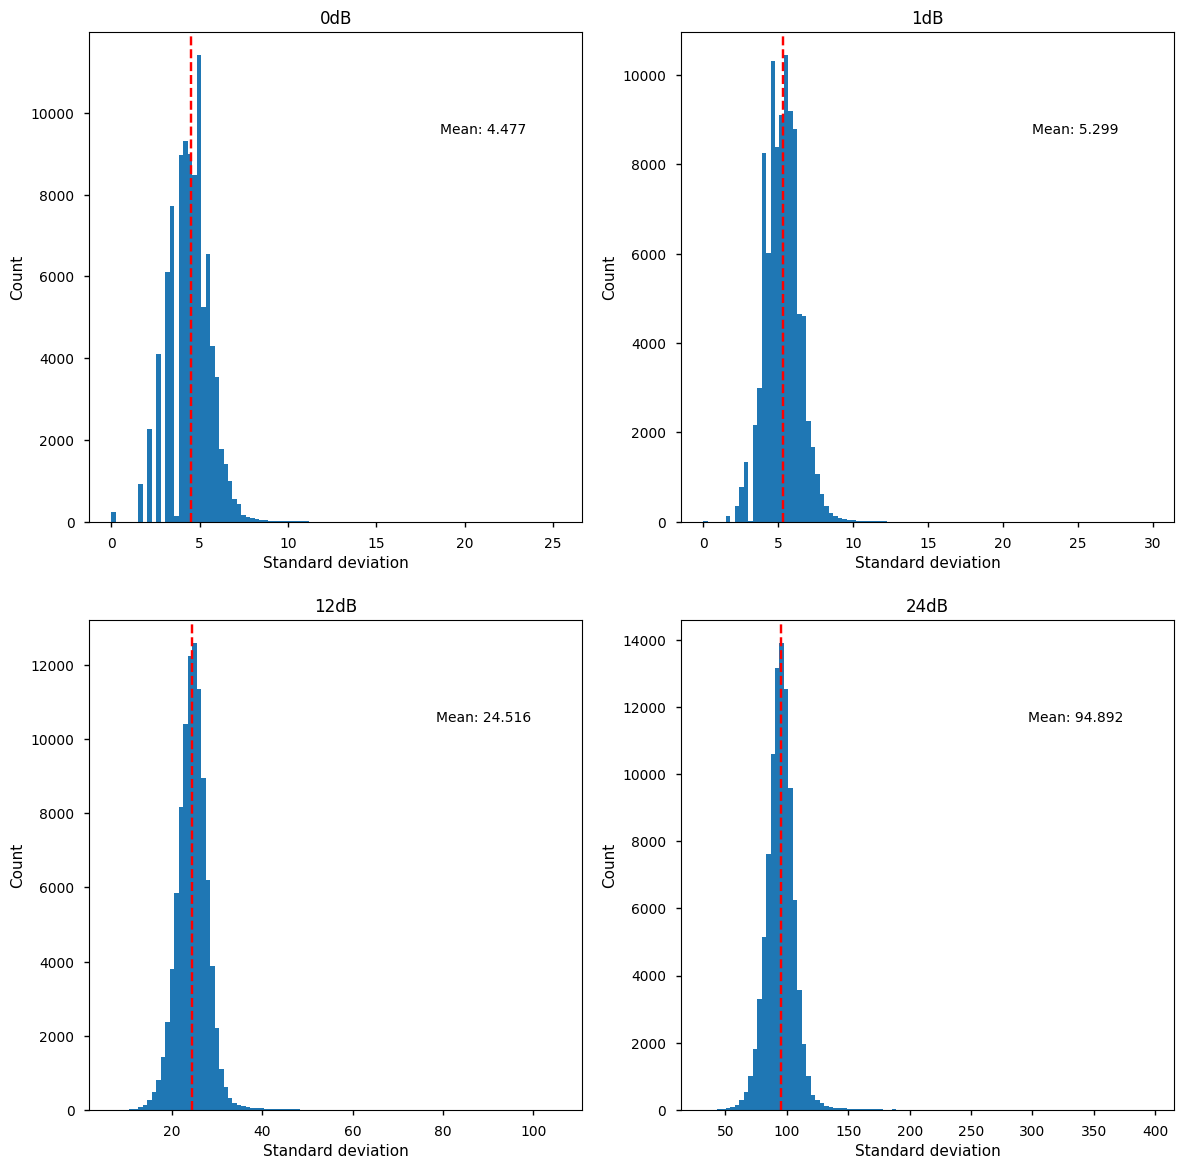

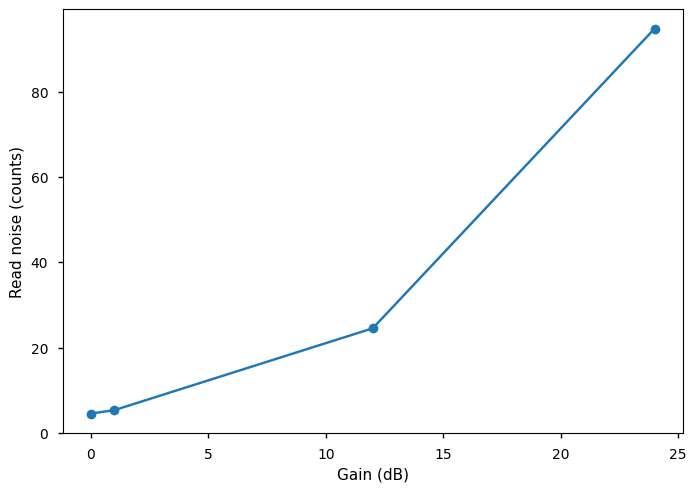

In [19]:
gain_levels = [0, 1, 12, 24]
read_noise_stub = 'practice_data/Basler_RAAC_2024_09_26/read/40us_'
downsample_by = 5

readout_noise = plot_readout_noise_multiple_gain(gain_levels, read_noise_stub, downsample_by)

## Measure dark counts

### Data:
A sequence of images (∼ 100) from the camera with NO light hitting the detector at a range of exposure times.

### Exercise instructions:
Measure the Mean number of counts in each image. 

Do the counts increase with increasing exposure time? How many counts/pixel/second do you observe? Hint: Remember to subtract the Bias Level, the average value (in counts) appearing in the image following a 0-second exposure. (This is an offset added to each image by the camera manufacturers and does not reflect the incident light level.)

In [20]:
def measure_dark_counts(im_data):
    return np.mean(im_data, axis=(1,2), dtype=np.float32)

def calc_plot_dark_counts(im_data, exposures):
    dark_counts = measure_dark_counts(im_data)
    bias = dark_counts[0]
    subtracted_counts = dark_counts - bias
    
    model_dark_noise = LinearRegression()
    model_dark_noise.fit(exposures.reshape(-1, 1), subtracted_counts)
    
    print(f'The slope of the dark noise is {model_dark_noise.coef_}')
    print(f'The y-intercept of the dark noise is {model_dark_noise.intercept_}')
    
    fig, ax = plt.subplots()
    ax.plot(exposures, subtracted_counts, marker='o')
    ax.set_xlabel('Exposure time (s)')
    ax.set_ylabel('Mean counts')
    plt.show()
    
    return dark_counts, subtracted_counts, model_dark_noise

Dark counts for 0dB
The slope of the dark noise is [16.60652079]
The y-intercept of the dark noise is -0.17026777686655947


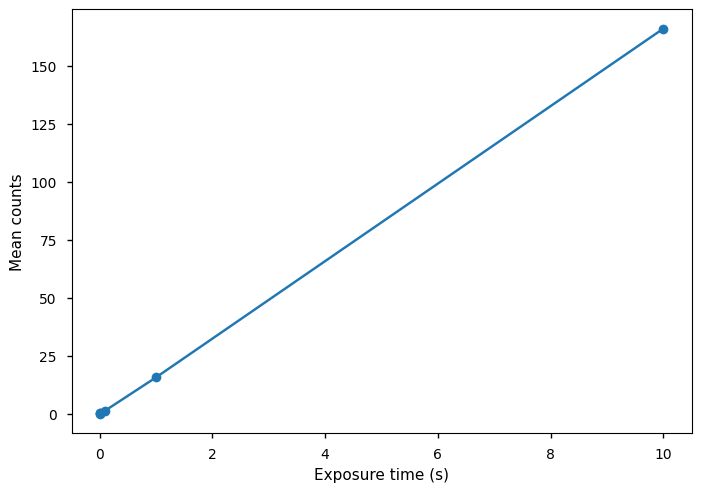

Dark counts for 1dB
The slope of the dark noise is [23.39925113]
The y-intercept of the dark noise is -0.06198283069965527


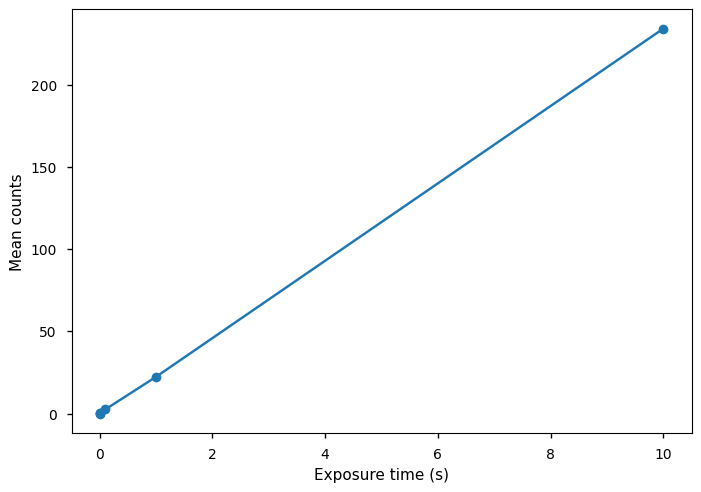

Dark counts for 12dB
The slope of the dark noise is [92.98866721]
The y-intercept of the dark noise is -1.2873069454201982


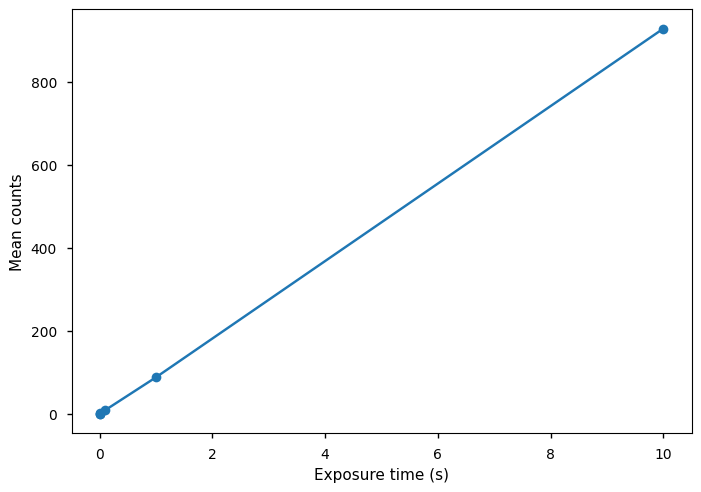

Dark counts for 24dB
The slope of the dark noise is [449.63616342]
The y-intercept of the dark noise is -5.266089967037033


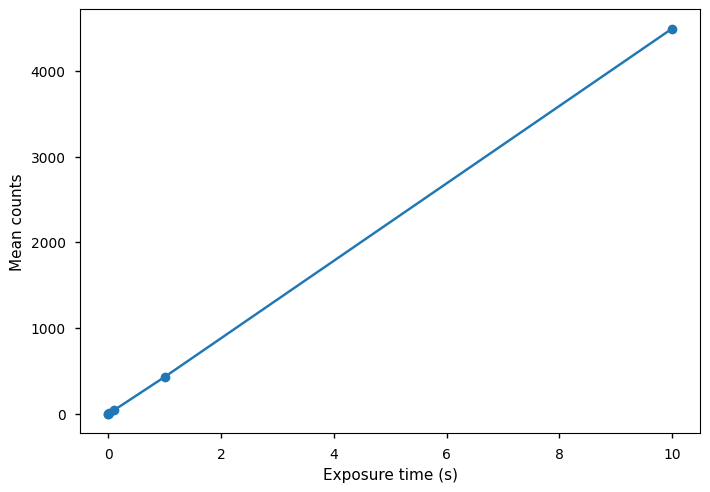

In [21]:
dark_counts_stub = 'practice_data/Basler_RAAC_2024_09_26/dark_noise/dark_noise'
dark_count_results = []

for i, gain in enumerate(gain_levels):
    print(f'Dark counts for {gain}dB')
    full_path = f'{dark_counts_stub}/{gain}dB/'
    dark_images = load_tiff_directory(full_path)

    exposures = np.array([0.00004, 0.001, 0.01, 0.1, 1, 10])
        
    dark_count_results.append(calc_plot_dark_counts(dark_images, exposures))
    

## Compute the dynamic range of the camera

First determine the cameras full well capacity (saturation value) in counts after bias removal.

Use a long exposure and expose the camera to a bright light source. What value are saturated
pixels assigned? Use the formula below to compute the cameras dynamic range (the number of
individually discernible light levels) for a fixed exposure.
$$
\text{Dynamic Range} = (\text{Saturation} - \text{Dark counts}) / \text{Read-out noise}
$$
Note: Use bias subtracted values for both Saturation and Dark counts.
Compare your results to the cameras technical specification sheet.

In [11]:
gain_index = 1
bias = dark_count_results[gain_index][0][0]
sat_value = 65535 - bias
dark_count = dark_count_results[gain_index][1][1]
print(f'Saturated pixels are assigned the value {sat_value}')
print(f'Full well capacity at 1 ms exposure and 24 gain is {sat_value - dark_count:.0f}')

dynamic_range = (sat_value - dark_count) / readout_noise[gain_index]

print(f'The dynamic range of the camera is {dynamic_range:.0f}')

Saturated pixels are assigned the value 65383.7578125
Full well capacity at 1 ms exposure and 24 gain is 65383
The dynamic range of the camera is 35915


## Measure shot noise

### Data:
Acquire sequences of images (100) with the camera exposed to a wide distribution of brightness values. You can do this in two ways:
- Use a range of pixel intensities within an image: structured sample illuminated at a fixed intensity. Measure the mean and standard deviation for each pixel across the image sequence.
- Use 1 second exposure time, the illumination light must be stable; use an LED in an enclosed container (to avoid background changes).

### Exercise instructions:
Plot the variance, i.e. standard deviation squared (Y axis) vs. mean (X axis) for different brightness levels. Fit a line. Determine the detectors gain (counts per photoelectron):

Hint: Remember to subtract out the Bias Level measured above. 

Note: The slope of the line will be the Gain of your camera.

Where does the fit line intersect the y-axis? Does this make sense?

In [22]:
def calculate_plot_shot_noise(image_path, offset, downsample=5):
    shot_image = load_tiff_directory(image_path) - offset
    mean = np.mean(shot_image, axis=0, dtype=np.float32).reshape(-1, 1)
    var = np.var(shot_image, axis=0, ddof=1, dtype=np.float32).reshape(-1, 1)
    
    model = LinearRegression()
    model.fit(mean, var)

    
    best_fit = model.predict(mean)
        
    print(f'The gain of the camera is {model.coef_[0][0]:.3f}')
    print(f'The y-intercept is {model.intercept_[0]:.3f}')
    
    fig, ax = plt.subplots()
    ax.scatter(mean[::downsample], var[::downsample])
    ax.plot(mean, best_fit, color='r', linestyle='--')
    ax.set_xlabel('Mean counts')
    ax.set_ylabel('Variance')
    
    plt.show()

    return model.coef_[0][0], model.intercept_[0]

Shot noise for 12dB 10 ms exposure
The gain of the camera is 8.004
The y-intercept is 6475.438


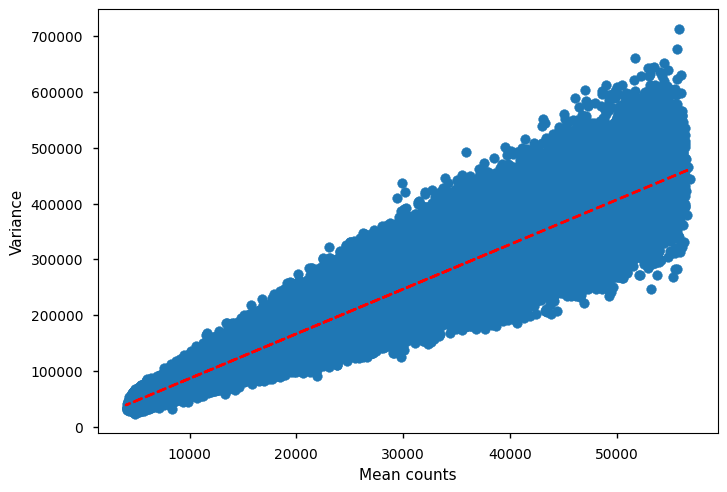

Shot noise for 12dB 100 ms exposure
The gain of the camera is 8.150
The y-intercept is 3277.875


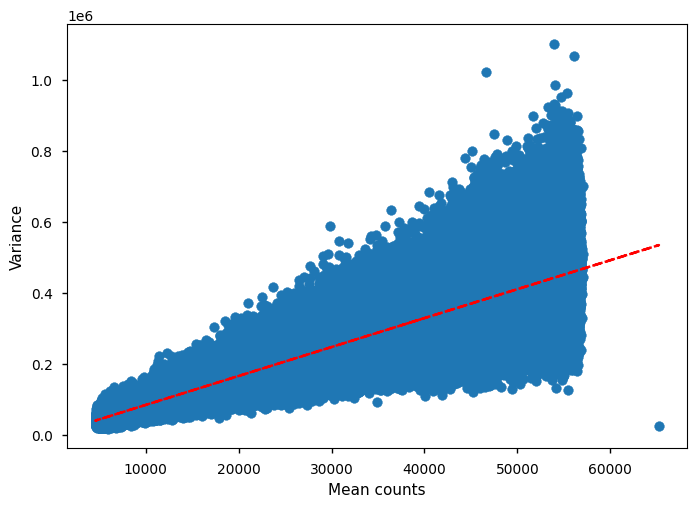

In [23]:
print("Shot noise for 12dB 10 ms exposure")
bias = dark_count_results[2][0][0]
shot_noise_10ms_12db_path = 'practice_data/Basler_RAAC_2024_09_26/shot/10ms_12dB/'
shot_noise_10ms_12db_gain, shot_noise_10ms_12db_intercept = calculate_plot_shot_noise(shot_noise_10ms_12db_path, bias)

print("Shot noise for 12dB 100 ms exposure")
shot_noise_100ms_12db_path = 'practice_data/Basler_RAAC_2024_09_26/shot/100ms_12dB/'
shot_noise_100ms_12db_gain, shot_noise_100ms_12db_intercept = calculate_plot_shot_noise(shot_noise_100ms_12db_path, bias)

In [24]:
readout_noise_e = readout_noise[2] / shot_noise_10ms_12db_gain
print(f"Read noise in e- for 12 dB is: {readout_noise_e:.3f}")

Read noise in e- for 12 dB is: 2.441
